In [101]:
import numpy as np
import warnings
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE


np.random.seed(42)

In [83]:
wine = pd.read_csv("~/ucare-summer2020/datasets/winequality-white.csv", sep=";")

X = wine.drop(columns=['quality'])
y = wine['quality']
y = y > 5
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [4]:
def report_clf(clf):
    y_train_predicted = clf.predict(X_train)
    y_test_predicted = clf.predict(X_test)
    print("\nTrain Accuracy: ", np.mean(y_train_predicted == y_train))
    print("-----------------------------------------")
    print("\nTest Accuracy: ", np.mean(y_test_predicted == y_test))
    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_predicted))


    precision_test = precision_score(y_test, y_test_predicted) 
    print("\nTest Precision = %f" % precision_test)

    recall_test = recall_score(y_test, y_test_predicted)
    print("Test Recall = %f" % recall_test)


    f1_test = f1_score(y_test, y_test_predicted)
    print("Test F1 Score = %f" % f1_test)


    print("\nClassification Report:")
    print(classification_report(y_test, y_test_predicted))

In [57]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X.iloc[:,0].min() - 0.01, X.iloc[:, 0].max() + 0.01
    
    # Get the min and max value of feature x2
    x2min, x2max = X.iloc[:,1].min() - 0.01, X.iloc[:, 1].max() + 0.01
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.binary, alpha=0.8)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()

In [58]:
def plot_boundary_clf(clf, X):
    plt.figure(figsize=(12, 6))

    decision_boundary_class_colored(clf, X)

    plt.plot(X[y==0].iloc[:,0], X[y==0].iloc[:,1], "bo", ms=3)
    plt.plot(X[y==1].iloc[:,0], X[y==1].iloc[:,1], "go", ms=3)
    
    bp = 99.9 #boundary percentile for axis scaling
    xmin0, xmax0 = np.percentile(X.iloc[:,0], 100-bp), np.percentile(X.iloc[:,0], bp)
    xmin1, xmax1 = np.percentile(X.iloc[:,1], 100-bp), np.percentile(X.iloc[:,1], bp)
    plt.axis([xmin0, xmax0, xmin1, xmax1])
    plt.annotate('Bad Wine', xy=(0.85, 0.95), xycoords='axes fraction', color="b")
    plt.annotate('Good Wine', xy=(0.85, 0.85), xycoords='axes fraction', color="g")
    plt.xlabel("Feature 1", fontsize=14)
    plt.ylabel("Feature 2", fontsize=14)
    plt.title("SVM Decision Boundary Plot", fontsize=16)
    plt.show()

In [69]:
scaler = StandardScaler()

In [55]:
def run_SVM_PCA(C, gamma):
    print("SVM grid search with PCA")
    param_grid = {'svc__kernel': ['rbf'], 'svc__max_iter': [10000],
                     'svc__C': C, 'svc__gamma': gamma, 'pca__n_components': [2,3,4,5,6,7,8,9,10,11]}
    svm_clf = SVC()
    pca = PCA()
    pca_clf = Pipeline([
        ("scaler", scaler),
        ("pca", pca),
        ("svc", svm_clf)
    ])
    pca_clf_cv = GridSearchCV(pca_clf, param_grid, scoring='accuracy',
                            cv=3, verbose=1, n_jobs=-1)
    
    pca_clf_cv.fit(X_train, y_train)
    params_optimal = pca_clf_cv.best_params_
    print("Optimal Hyperparameter Values: ", params_optimal)
    print("\n")
    
    clf = pca_clf_cv
    report_clf(clf)

In [56]:
C = [0.001, 0.01, 1, 10, 1000]
gamma = [0.0001, 0.01, 1, 10, 100, 1000]
run_SVM_PCA(C, gamma);

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  2.5min finished


Optimal Hyperparameter Values:  {'pca__n_components': 8, 'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf', 'svc__max_iter': 10000}



Train Accuracy:  0.9507401735579377
-----------------------------------------

Test Accuracy:  0.8030612244897959

Test Confusion Matrix:
[[180 141]
 [ 52 607]]

Test Precision = 0.811497
Test Recall = 0.921093
Test F1 Score = 0.862829

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.56      0.65       321
           1       0.81      0.92      0.86       659

    accuracy                           0.80       980
   macro avg       0.79      0.74      0.76       980
weighted avg       0.80      0.80      0.79       980



PCA for two dimensions:


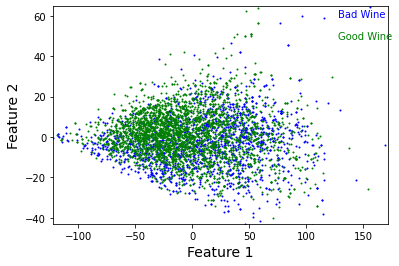

In [96]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)

plt.plot(X_pca[y==0].iloc[:,0], X_pca[y==0].iloc[:,1], "bo", ms=1)
plt.plot(X_pca[y==1].iloc[:,0], X_pca[y==1].iloc[:,1], "go", ms=1)

bp = 99.9 #boundary percentile for axis scaling
xmin0, xmax0 = np.percentile(X_pca.iloc[:,0], 100-bp), np.percentile(X_pca.iloc[:,0], bp)
xmin1, xmax1 = np.percentile(X_pca.iloc[:,1], 100-bp), np.percentile(X_pca.iloc[:,1], bp)
plt.axis([xmin0, xmax0, xmin1, xmax1])
plt.annotate('Bad Wine', xy=(0.85, 0.95), xycoords='axes fraction', color="b")
plt.annotate('Good Wine', xy=(0.85, 0.85), xycoords='axes fraction', color="g")
plt.xlabel("Feature 1", fontsize=14)
plt.ylabel("Feature 2", fontsize=14)
print("PCA for two dimensions:")

In [70]:
def run_KNN_PCA():
    print("KNN grid search with PCA")
    param_grid = {'knn__n_neighbors': np.arange(1,50,8), 'knn__p': [1,2,3], 
                  'knn__weights': ["uniform", "distance"],
                  'pca__n_components': [2,3,4,5,6,7,8,9,10,11]}

    knn_clf = KNeighborsClassifier()
    pca = PCA()
    pca_clf = Pipeline([
        ("scaler", scaler),
        ("pca", pca),
        ("knn", knn_clf)
    ])
    pca_clf_cv = GridSearchCV(pca_clf, param_grid, scoring='accuracy',
                            cv=3, verbose=1, n_jobs=-1)
    pca_clf_cv.fit(X_train, y_train)
    params_optimal = pca_clf_cv.best_params_
    print("Optimal Hyperparameter Values: ", params_optimal)
    print("\n")
    
    clf = pca_clf_cv
    report_clf(clf)

In [75]:
run_KNN_PCA()

SVM grid search with PCA
Fitting 3 folds for each of 1360 candidates, totalling 4080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 996 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2190 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2832 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3534 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4080 out of 4080 | elapsed:  5.1min finished


Optimal Hyperparameter Values:  {'knn__n_neighbors': 46, 'knn__p': 2, 'knn__weights': 'distance', 'pca__n_components': 10}



Train Accuracy:  1.0
-----------------------------------------

Test Accuracy:  0.823469387755102

Test Confusion Matrix:
[[203 118]
 [ 55 604]]

Test Precision = 0.836565
Test Recall = 0.916540
Test F1 Score = 0.874728

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.63      0.70       321
           1       0.84      0.92      0.87       659

    accuracy                           0.82       980
   macro avg       0.81      0.77      0.79       980
weighted avg       0.82      0.82      0.82       980



LDA for one dimension:


<ipython-input-100-80e3a26f066c>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  length1 = len(X_lda[y==0].iloc[:,0])
<ipython-input-100-80e3a26f066c>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  length2 = len(X_lda[y==1].iloc[:,0])
<ipython-input-100-80e3a26f066c>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(X_lda[y==0].iloc[:,0], zeros, "bo", ms=1)
<ipython-input-100-80e3a26f066c>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(X_lda[y==1].iloc[:,0], zeros2, "go", ms=1)


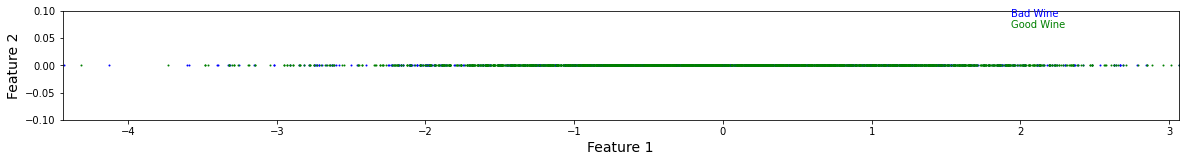

In [100]:
plt.figure(figsize=(20,2))

lda = LinearDiscriminantAnalysis(n_components=1)

X_lda = lda.fit(X_train, y_train).transform(X_train)
X_lda = pd.DataFrame(X_lda)
length1 = len(X_lda[y==0].iloc[:,0])
length2 = len(X_lda[y==1].iloc[:,0])
zeros = np.zeros(length)
zeros2 = np.zeros(length2)

plt.plot(X_lda[y==0].iloc[:,0], zeros, "bo", ms=1)
plt.plot(X_lda[y==1].iloc[:,0], zeros2, "go", ms=1)

bp = 99.9 #boundary percentile for axis scaling
xmin0, xmax0 = np.percentile(X_lda.iloc[:,0], 100-bp), np.percentile(X_lda.iloc[:,0], bp)
xmin1, xmax1 = -0.1, 0.1
plt.axis([xmin0, xmax0, xmin1, xmax1])
plt.annotate('Bad Wine', xy=(0.85, 0.95), xycoords='axes fraction', color="b")
plt.annotate('Good Wine', xy=(0.85, 0.85), xycoords='axes fraction', color="g")
plt.xlabel("Feature 1", fontsize=14)
plt.ylabel("Feature 2", fontsize=14)
print("LDA for one dimension:")

In [110]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
%time X_tsne = tsne.fit_transform(X_train)
X_tsne = pd.DataFrame(X_tsne, index=X_train.index)

CPU times: user 1min 28s, sys: 1.25 s, total: 1min 30s
Wall time: 25 s


t-SNE for two dimensions:


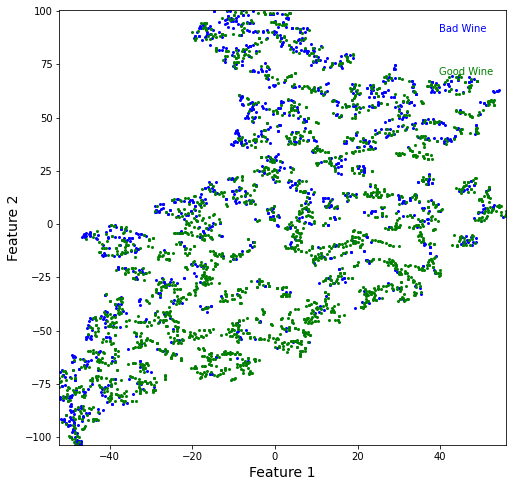

In [112]:
plt.figure(figsize=(8,8))

plt.plot(X_tsne[y_train==0].iloc[:,0], X_tsne[y_train==0].iloc[:,1], "bo", ms=2)
plt.plot(X_tsne[y_train==1].iloc[:,0], X_tsne[y_train==1].iloc[:,1], "go", ms=2)

bp = 99.9 #boundary percentile for axis scaling
xmin0, xmax0 = np.percentile(X_tsne.iloc[:,0], 100-bp), np.percentile(X_tsne.iloc[:,0], bp)
xmin1, xmax1 = np.percentile(X_tsne.iloc[:,1], 100-bp), np.percentile(X_tsne.iloc[:,1], bp)
plt.axis([xmin0, xmax0, xmin1, xmax1])
plt.annotate('Bad Wine', xy=(0.85, 0.95), xycoords='axes fraction', color="b")
plt.annotate('Good Wine', xy=(0.85, 0.85), xycoords='axes fraction', color="g")
plt.xlabel("Feature 1", fontsize=14)
plt.ylabel("Feature 2", fontsize=14)
print("t-SNE for two dimensions:")